In [ ]:
! pip install keras
import numpy as np
from keras.preprocessing import image
from keras import backend as K
from PIL import Image

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from skimage.io import imread
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from utils import blackbox_inference, submit

token = "8ZYRkMBfW1"

# 1. Whitebox

## a) Loading Model

In [ ]:
model = load_model("model-final.h5")
print(model)

## b) Loading image

In [5]:
im = imread("Images/whitebox/1.ppm")

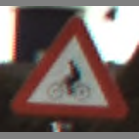

In [6]:
im_pil = Image.fromarray(im)
im_pil

## c) Loading Test set

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images



## c) Inference

In [7]:

# Grab a reference to the first and last layer of the neural net
model_input_layer = model.layers[0].input
model_output_layer = model.layers[-1].output



object_type_to_fake = 859

# Load the image to hack
im_pil = image.load_img("cat.png", target_size=(299, 299))
original_image = image.img_to_array(img)

# Scale the image so all pixel intensities are between [-1, 1] as the model expects
original_image /= 255.
original_image -= 0.5
original_image *= 2.

# Add a 4th dimension for batch size (as Keras expects)
original_image = np.expand_dims(original_image, axis=0)

# Pre-calculate the maximum change we will allow to the image
# We'll make sure our hacked image never goes past this so it doesn't look funny.
# A larger number produces an image faster but risks more distortion.
max_change_above = original_image + 0.01
max_change_below = original_image - 0.01

# Create a copy of the input image to hack on
hacked_image = np.copy(original_image)

# How much to update the hacked image in each iteration
learning_rate = 0.1

# Define the cost function.
# Our 'cost' will be the likelihood out image is the target class according to the pre-trained model
cost_function = model_output_layer[0, object_type_to_fake]

# We'll ask Keras to calculate the gradient based on the input image and the currently predicted class
# In this case, referring to "model_input_layer" will give us back image we are hacking.
gradient_function = K.gradients(cost_function, model_input_layer)[0]

# Create a Keras function that we can call to calculate the current cost and gradient
grab_cost_and_gradients_from_model = K.function([model_input_layer, K.learning_phase()], [cost_function, gradient_function])

cost = 0.0

# In a loop, keep adjusting the hacked image slightly so that it tricks the model more and more
# until it gets to at least 80% confidence
while cost < 0.80:
    # Check how close the image is to our target class and grab the gradients we
    # can use to push it one more step in that direction.
    # Note: It's really important to pass in '0' for the Keras learning mode here!
    # Keras layers behave differently in prediction vs. train modes!
    cost, gradients = grab_cost_and_gradients_from_model([hacked_image, 0])

    # Move the hacked image one step further towards fooling the model
    hacked_image += gradients * learning_rate

    # Ensure that the image doesn't ever change too much to either look funny or to become an invalid image
    hacked_image = np.clip(hacked_image, max_change_below, max_change_above)
    hacked_image = np.clip(hacked_image, -1.0, 1.0)

    print("Model's predicted likelihood that the image is a toaster: {:.8}%".format(cost * 100))

# De-scale the image's pixels from [-1, 1] back to the [0, 255] range
img = hacked_image[0]
img /= 2.
img += 0.5
img *= 255.

# Save the hacked image!
im = Image.fromarray(img.astype(np.uint8))
im.save("hacked-image.png")
view rawgenerated_hacked_image.py hosted with ❤ by GitHub

NameError: name 'object_type_to_fake' is not defined